# Projeto 18: Compactação de imagens com Convolucional Autoencoders

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

## Etapa 1: Importação das bibliotecas

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [4]:
data_train = datasets.MNIST('MNIST-data', train = True, download=True,
                               transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(data_train, batch_size=256,
                                           shuffle = True)

In [5]:
data_test = datasets.MNIST('MNIST-data', train = False, download=True,
                           transform = transforms.ToTensor())
loader_test = torch.utils.data.DataLoader(data_test, batch_size=256,
                                          shuffle=True)

## Etapa 3: Construção do autoencoder

In [11]:
# 784 -> 128 -> 64 -> 32 -> 64 -> 128 -> 784
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # CAMADAS DO ENCODER
    self.encoder0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3))
    self.encoder1 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3), padding=(1,1))
    self.encoder2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), stride=(2,2), padding=(1,1))

    self.maxpool0 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), padding=(1,1))

    self.flatten = nn.Flatten()

    # CAMADA DO DECODER
    self.decoder0 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), padding=(1,1))
    self.decoder1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), padding=(1,1))
    self.decoder2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3))
    self.decoder3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3,3), padding=(1,1))

    self.upsampling = nn.UpsamplingBilinear2d(scale_factor=2)

    # CAMADAS DE ATIVAÇÃO
    self.activation0 = nn.ReLU()
    self.activation1 = nn.Sigmoid()

  def forward(self, X):
    # ESTRUTURA DO ENCODER    
    X = self.maxpool0(self.activation0(self.encoder0(X)))
    X = self.maxpool1(self.activation0(self.encoder1(X)))
    X = self.flatten(self.activation0(self.encoder2(X)))
    X = X.view(-1, 8, 4, 4) # O número de canais (ou filtros) vai na segunda dimensão
    # ESTRUTURA DO DECODER
    X = self.upsampling(self.activation0(self.decoder0(X)))
    X = self.upsampling(self.activation0(self.decoder1(X)))
    X = self.upsampling(self.activation0(self.decoder2(X)))
    X = self.activation1(self.decoder3(X))
    return X

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [13]:
model = autoencoder()
model.to(device)

autoencoder(
  (encoder0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (encoder1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (decoder0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (decoder3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [15]:
for epoch in range(20):
  # TREINAMENTO
  running_loss_train = 0.
  for data in loader_train:
    model.train()
    inputs, _ = data
    inputs = inputs.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    loss.backward()

    optimizer.step()

    running_loss_train += loss.item()

  # VALIDAÇÃO
  running_loss_val = 0.
  for data in loader_test:
    model.eval()
    inputs, _ = data
    inputs = inputs.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    running_loss_val += loss.item()

  print('ÉPOCA {:3d}: PERDA TREINO {:.5f} | PERDA VALIDAÇÃO {:.5f}' \
        .format(epoch+1, running_loss_train/len(loader_train), running_loss_val/len(loader_test)))

ÉPOCA   1: PERDA TREINO 0.35608 PERDA VALIDAÇÃO 0.22599
ÉPOCA   2: PERDA TREINO 0.20831 PERDA VALIDAÇÃO 0.18808
ÉPOCA   3: PERDA TREINO 0.17650 PERDA VALIDAÇÃO 0.16614
ÉPOCA   4: PERDA TREINO 0.16189 PERDA VALIDAÇÃO 0.15641
ÉPOCA   5: PERDA TREINO 0.15480 PERDA VALIDAÇÃO 0.15076
ÉPOCA   6: PERDA TREINO 0.15012 PERDA VALIDAÇÃO 0.14726
ÉPOCA   7: PERDA TREINO 0.14699 PERDA VALIDAÇÃO 0.14429
ÉPOCA   8: PERDA TREINO 0.14438 PERDA VALIDAÇÃO 0.14198
ÉPOCA   9: PERDA TREINO 0.14227 PERDA VALIDAÇÃO 0.13991
ÉPOCA  10: PERDA TREINO 0.14034 PERDA VALIDAÇÃO 0.14030
ÉPOCA  11: PERDA TREINO 0.13871 PERDA VALIDAÇÃO 0.13708
ÉPOCA  12: PERDA TREINO 0.13707 PERDA VALIDAÇÃO 0.13614
ÉPOCA  13: PERDA TREINO 0.13578 PERDA VALIDAÇÃO 0.13408
ÉPOCA  14: PERDA TREINO 0.13446 PERDA VALIDAÇÃO 0.13422
ÉPOCA  15: PERDA TREINO 0.13332 PERDA VALIDAÇÃO 0.13213
ÉPOCA  16: PERDA TREINO 0.13215 PERDA VALIDAÇÃO 0.13071
ÉPOCA  17: PERDA TREINO 0.13107 PERDA VALIDAÇÃO 0.12914
ÉPOCA  18: PERDA TREINO 0.12999 PERDA VALIDAÇÃO 

## Etapa 5: Geração do encoder

In [16]:
for i, layer in enumerate(list(model.children())):
  print(i, layer)

0 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
1 Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
4 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
5 Flatten()
6 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
9 Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
11 ReLU()
12 Sigmoid()


In [17]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder0 = list(model.children())[0]     # Conv2d => 1 -> 16
    self.encoder1 = list(model.children())[1]     # Conv2d => 16 -> 8
    self.encoder2 = list(model.children())[2]     # Conv2d => 8 -> 8

    self.maxpool0 = list(model.children())[3]
    self.maxpool1 = list(model.children())[4]

    self.flatten = list(model.children())[5]

    self.activation0 = list(model.children())[11]  # RELU

  def forward(self, X):
    X = self.maxpool0(self.activation0(self.encoder0(X)))
    X = self.maxpool1(self.activation0(self.encoder1(X)))
    X = self.flatten(self.activation0(self.encoder2(X)))
    return X

In [18]:
model_enc = encoder()
model_enc.to(device)

encoder(
  (encoder0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (encoder1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [19]:
for i, layer in enumerate(list(model.children())):
  print(i, layer)

0 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
1 Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
4 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
5 Flatten()
6 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
9 Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
11 ReLU()
12 Sigmoid()


In [32]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder0 = list(model.children())[6]       # Conv2d => 8 -> 8
    self.decoder1 = list(model.children())[7]       # Conv2d => 8 -> 8
    self.decoder2 = list(model.children())[8]       # Conv2d => 8 -> 16
    self.decoder3 = list(model.children())[9]       # Conv2d => 16 -> 1

    self.upsampling = list(model.children())[10]

    self.activation0 = list(model.children())[11]    # Relu
    self.activation1 = list(model.children())[12]    # Sigmoid

  def forward(self, X):
    X = X.view(-1,8,4,4)
    X = self.upsampling(self.activation0(self.decoder0(X)))
    X = self.upsampling(self.activation0(self.decoder1(X)))
    X = self.upsampling(self.activation0(self.decoder2(X)))
    X = self.activation1(self.decoder3(X))
    return X

In [33]:
model_dec = decoder()
model_dec.to(device)

decoder(
  (decoder0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (decoder3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [34]:
num_images = 10
img_test = next(iter(loader_test))[0][:num_images]
img_test = img_test.to(device)

In [35]:
img_test.shape

torch.Size([10, 1, 28, 28])

In [36]:
model_enc.eval()
img_cod = model_enc(img_test)

In [37]:
img_cod.shape

torch.Size([10, 128])

In [38]:
model_dec.eval()
img_dec = model_dec(img_cod)

In [39]:
img_dec.shape

torch.Size([10, 1, 28, 28])

In [40]:
img_test = img_test.detach().cpu().numpy().reshape(-1,28,28)
img_cod = img_cod.detach().cpu().numpy().reshape(-1,16,8)
img_dec = img_dec.detach().cpu().numpy().reshape(-1,28,28)

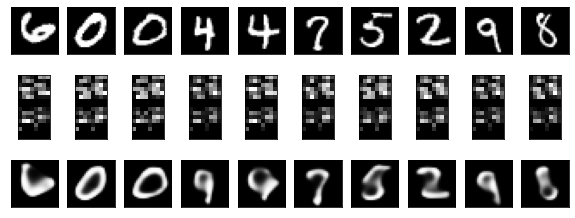

In [41]:
fig, axes = plt.subplots(3, num_images, figsize=(10,4))
for images, ax_row in zip([img_test, img_cod, img_dec], axes):
  for img,ax in zip(images, ax_row):
    ax.imshow(img,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)